# NATURE AND CHARACTERS OF INVERSE PROBLEMS # 

For a problem to be well-posed and well-conditioned, it has to have the following properties:

1. A solution exists.
2. The solution is unique.
3. The solution depends continuously on the data

Inverse problems are typically characterised as ill-posed and ill-conditioned. Practically, the solution may be unique, but there may be a large enough space of functions that all equally satisfy the conditions of the problem, and hereby violating the second condition. For example, given a specific mass distribution of an object, one can easily work out the graviational field around such object. Yet given the gravatational field, it is impossible to determine the corresponding mass distribution - there are too many possible combination of the parameters that can produce the given gravitational field. 

The third condition - *stability condition* - is generally violated by the problem itself. Our observations are contaminated with noise, meaning that a small changes in the data due to measurement errors can generate significant changes in the solution. 

In most cases of the inverse problems, the exist of a unique solution falls short is because there are more parameters than observations. Again, let's look at the gravitational field example. In the forward problem, given the mass of the objects and how far away it is from the point of inspection, the strength of the gravitational field can be determined. This means for two know parameters, we can use the forward solution to obtain one observation. In the inverse direction, we only have *one observation* to determine the values of *two parameters*. Hence, *a prior knowledge on the parameter* acting as a regularisation term is needed. 

Let's illustrate those points further by looking at one example of the polynomial fitting. 

## INVERSE PROBLEM EXAMPLE - POLYNOMIAL FITTING ## 

Suppose we have the to fit a polynomial $y$ onto the a 1D mesh of $x$ along the element in that:

$$
y_j = a_0 + a_1 x_j + a_2 x_j^2 + ... = \sum_{i=0}^{n} a_{i}x_j^{i}
$$

In this discretised form, this is written as:

$$
\mathbf{y = Aa}
$$

where $\mathbf{A}$ is the Vandermonde matrix of the mesh $x$, and $\mathbf{a}$ is a column vector storing the coefficients of the polynomial. 

For the forward problem, given any sets of coefficients, on that given mesh, the polynomial can be constructed straightforward. 

Numer of nodes:  10
Degree of polynomial:  4
[ 1.  1.  1.  1.  1.]
(10, 5)


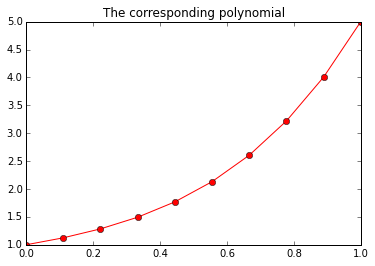

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

n = 10 # number of nodes on the mesh
x = np.linspace(0, 1, n)
print 'Numer of nodes: ', n

n_deg = 5 # Degree of vandermoore matrix
A = np.vander(x, n_deg)
print 'Degree of polynomial: ', n_deg-1

a = np.ones(n_deg)
#a = np.linspace(2*n_deg, 1, n_deg)
print a

# Now let's plot it the solution
y = A.dot(a)
plt.title('The corresponding polynomial')
plt.plot(x, y, '-ro')

print A.shape

Now given a certain number of points on the polynomial, can we reconstruct the coefficients of the polynomial? Given the ideal world where computers are efficiently fast to compute these matrix inversions and multiplication. One could 'restore' the coefficient vector $\mathbf{a}$ by using the *pseudo-inverse* of $\mathbf{A}$ which is an $m \times n$ matrix.

1. If A is full column rank, meaning mbox{bf rank}(A) = n le m, that is, A^TA is not singular, then A^dagger is a left inverse of A, in the sense that A^dagger A = I_n. We have the closed-form expression
$$
A^{\dagger} = (A^TA)^{-1}A^T.
$$

2. If A is full row rank, meaning mbox{bf rank}(A) = m le n, that is, AA^T is not singular, then A^dagger is a right inverse of A, in the sense that AA^dagger = I_m. We have the closed-form expression
$$
A^{\dagger} = A^T(AA^T)^{-1}. 
$$

The minimum norm, which is the solution for $a$ being $a^{\ast} = A^{\dagger} y$

In [2]:
def pseudo(A):# Check if A is full row rank or full column rank
    m,n = A.shape[0], A.shape[1]
    if m>=n:
        # full column rank, compute left inverse
        Aps = np.linalg.inv(A.T.dot(A)).dot(A.T)
    else:
        # full row rank, compute right inverse
        Aps = A.T.dot(np.linalg.inv(A.dot(A.T)))
    return Aps

print 'Coefficients: ', pseudo(A).dot(y)

Coefficients:  [ 1.  1.  1.  1.  1.]


But what if we have noisy observation $\tilde{y} = y + n$ where $n$ represents the noise level in the data? Let's compute this with the exact solution. 

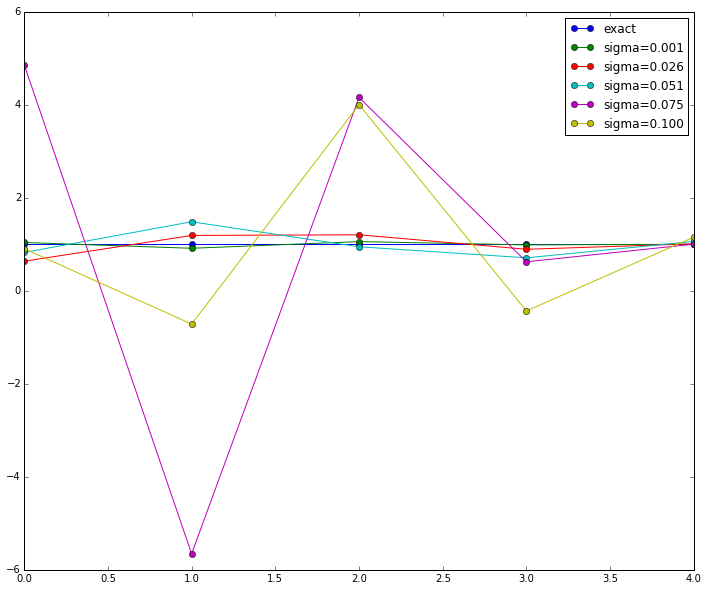

In [3]:
sigma_range = np.linspace(0.001, 0.1, 5) # Let's generate some range of sigma_data

plt.figure(figsize=(12,10))
plt.plot(a, '-o', label='exact')
for sigma_data in sigma_range:
    yn = y + np.amin(y)*np.random.normal(0, sigma_data, y.size)
    an = pseudo(A).dot(yn)
    #print "L2 norm difference: ", np.linalg.norm(an - a)

    # Lets plot some graph to see how different they are
    plt.plot(an,'-o', label='sigma=%1.3f'%sigma_data)

plt.legend()

It can be observed that even if a little amount of noise is added to the observation data, our obtained results differ significantly from the expected one. The deterministic approach to inverse problems, which amounts to minimizing a regularised data misfit function, does not accoutn for uncertainties in the solution of the inverse problem. On the other hand, **Bayesian inference** provides a systematic framework for incorporating uncertainties in observations, forward models and prior knowledge to quantify uncertainties in the parameters. In order to add resularisation terms to our objective cost function, we need to have some prior expectation on our parameter, say $\mathbf{x_{prior}}$. 

From Flath et al, solving the MAP point of this inverse problem is equivalent to solving a weighted least squares optimisation problem in which:

$$
\bar{\mathbf{a}}_{post} = arg \min_{x} \Big( \dfrac{1}{2} || \tilde{\mathbf{y}} - \mathbf{Aa}|| ^{2}_{\Gamma^{-1}_{noise}}+ \dfrac{1}{2} || \mathbf{a} - \mathbf{\bar{a}_{prior}} ||^{2}_{\Gamma^{-1}_{prior}}\Big)
$$

which, in vector forms, and we assume that the noise has zero mean, and assume that our noise and prior covariance is constant, is equivalent to:

Or in vector form:
$$
\mathbf{\Pi} = \dfrac{1}{2\sigma_{data}}(\mathbf{\tilde{y} - Aa})^{T}(\mathbf{\tilde{y} - Aa}) + \dfrac{1}{2\sigma_{prior}}(\mathbf{a - \bar{a}_{prior}})^{T}(\mathbf{a - \bar{a}_{prior}}) 
$$

Assume that there exists a solution $\mathbf{\hat{x}}$ that minimise $\mathbf{\Pi}$, differentiate $\mathbf{\Pi}$ with respect to $\mathbf{\hat{x}}$ and equal the derivative to zero gives us the following linear algebra problem:

$$
\Big[ \dfrac{1}{\sigma_{data}} \mathbf{A}^{T}\mathbf{A} + \dfrac{1}{\sigma_{prior}} \mathbf{I} \Big] \mathbf{a} = \dfrac{1}{\sigma_{prior}} \mathbf{a_{prior}} + \dfrac{1}{\sigma_{data}} \mathbf{A}^{T}\mathbf{\tilde{y}}
$$

The equation above can be turned into a $\mathbf{Ma = k}$ problem with:

$$
\mathbf{M} = \dfrac{1}{\sigma_{data}} \mathbf{A}^{T}\mathbf{A} + \dfrac{1}{\sigma_{prior}} \mathbf{I}
$$

$$
\mathbf{k} = \dfrac{1}{\sigma_{data}} \mathbf{A}^{T}\mathbf{\tilde{y}} + \dfrac{1}{\sigma_{prior}} \mathbf{a_{prior}}
$$

In [4]:
# Now let's throw in some data, and sigma
sigma_data = 0.1
sigma_prior = 0.1

Errors:  0.0347935442367


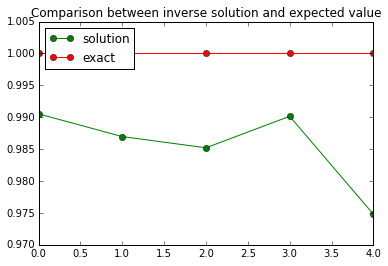

In [5]:
# And now try to define prior solution of a
a_prior = np.ones(n_deg) # this is way too good for a prior...
yn = y + np.amin(y)*np.random.normal(0, sigma_data, y.size)

# Then solve the optimisation problem
M = (1.0/sigma_data)*A.T.dot(A) + (1.0/sigma_prior)*(np.identity(n_deg))
k = (1.0/sigma_data)*A.T.dot(yn) + (1.0/sigma_prior)*a_prior

a_hat = np.linalg.solve(M, k)

# Let's plot and compare this with our exact
plt.title('Comparison between inverse solution and expected value')
plt.plot(a_hat,'-go', label='solution')
plt.plot(a,'-ro',label='exact')
plt.legend(loc=2)
print 'Errors: ', np.linalg.norm(a-a_hat)

## REMARKS ##

Even though we have achieved a smaller $L_{2}$ norm for our results, there are several factors that have been made available in this example. 

1. In this simple example, it is observed that even a small amount of noise added, we can see the extreme behaviour on our obtained parameter. This is where the prior is needed in order to shift the parameter toward our prior knowledge. In otherwords, the entire problem can be viewed as a combine of small optimisation problem. In case $\sigma_{data}$ overshoots, the optimisation problem will be shifted toward optimising $\mathbf{\hat{x}}$ that is closer to $\mathbf{x}_{prior}$ instead. And vice versa, if we don't have a strong prior, then the solution will be shifted toward our data prediction instead. 
2. The *prior* has been selected to be *too conveniently* biased our solution of parameters. In the real scenario, if our prior is, originally, differed from what the exact result maybe, we could well never achieve close to our solution. 
3. On the topic of *"coming close to our exact solution"*, in the practical problem we don't have our exact solution available there to compute our $L_{2}$ norm directly. Instead, we will arrive at a solution without sufficient knowledge whether how close or how good that solution is. To determine the uncertainty in our solution, **uncertainty quantification (UQ)** is required. UQ is the science of quantitative characterization and reduction of uncertainties in both computational and real world applications. It tries to determine how likely certain outcomes are if some aspects of the system are not exactly known
4. In the inverse problem, UQ is phrased as followed: "Given some experimental measurements of a system and some computer simulation results from its mathematical model, inverse UQ estimates the discrepancy between the experiment and the mathematical model, and estimates the values of unknown parameters in the model if there are any."
5. However, Bayesian solution of the statistical inverse problem for expensive forward models and for large numbers of parameters (as occurs when spatially varying fields are discretized) is essentially intractable using conventional sampling techniques. 
6. In this example, and in the following cases of the notebook, we consider the case of a linear ill-posed inverse problem within the frame-work of Bayesian inference. The relevant background is summarized in section 2. For this class of problems, an additive Gaussian noise model and a Gaussian prior density on the model parameters will result in a Gaussian posterior density for the model parameters. Thus, the statistical solution of the inverse problem, i.e., *the posterior density*, can be completely described by its *mean* and *covariance matrix*. The mean is given by maximizing the posterior density, which leads to a linear least squares optimization problem whose structure is identical to that of a properly weighted deterministic inverse problem.
7. On the other hand, computing the covariance matrix is not nessarily that straightforward. The posterior covariance matrix $\Gamma_{post}$ is given by the inverse of the Hessian matrix of this least squares function. Due to the high dimensionality of the parameter space and expense of solving the underlying forward PDEs needed to construct the Hessian, direct computation of $\Gamma_{post}$ is usually intractable. Moreover, the explicit inverse of the Hessian is not required for deterministic inversion, and thus one cannot appeal to deterministic techniques for computing $\Gamma_{post}$ directly.
8. This project will focus on using **Conjugant Gradient Method** to solve the uncertainty quantification on the membrane problem. In the 1D case, the matrix of this least square function is symmetric, low-rank and positive definite (which is resulted from Finite Element Method formulation). Further discussion on why CG is chosen for this project will be discussed later on. 

The next notebook - [UQ on Inverse Problems on Membrane](MembraneInverseUQ.ipynb) -  will focus strongly on formulating and tackling the inverse UQ on our membrane problem.

[Overview](Overview.ipynb)